# Trabajo Práctico 3: Fashion detector

###  1. Análisis exploratorio sobre el conjunto de datos

In [1]:
## Herramientas
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Rescaling, Resizing
from keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomCrop, RandomZoom
from keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator

import plotly.express as px

%matplotlib inline

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
## Se obtienen los datos
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

PRENDAS = {0:'T-shirt/top', 1:'Trouser',
             2:'Pullover', 3:'Dress',
             4:'Coat', 5:'Sandal', 6:'Shirt',
             7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
## Dimensionalidad de los datos
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [4]:
## Etiquetas del dataset
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
## Estructura de una imagen
imagen = x_train[0]
imagen

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [301]:
## Funcion para dibujar algunas imagenes de ejemplo
def dibujar_imagenes(x_train, y_train):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_train[i])
        plt.title(PRENDAS[y_train[i]])
        plt.axis("off")

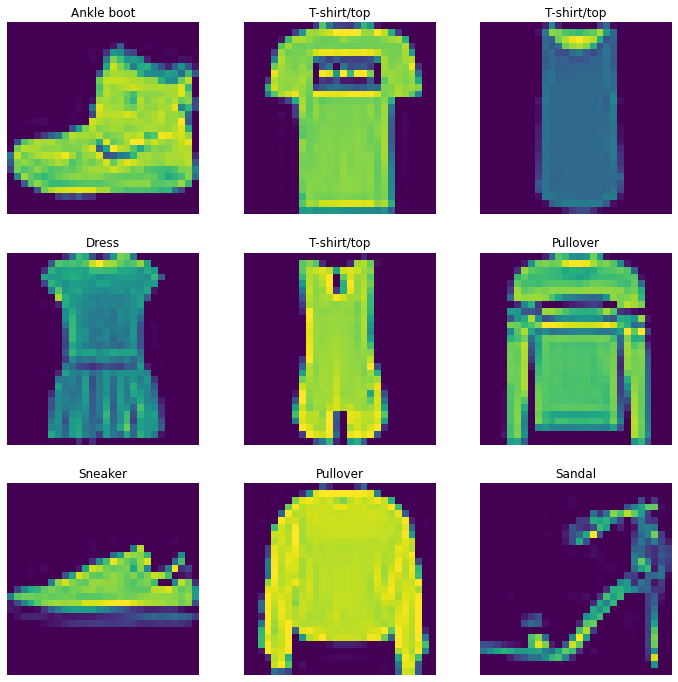

In [302]:
dibujar_imagenes(x_train, y_train)

Se cuenta con un conjunto de datos dividos en **train** y **test** con 60.000 y 10.000 imagenes respectivamente. Cada imagen es una matriz de **25 pixeles alto** por **25 pixeles de ancho** donde el valor de cada celda es un valor en la escala de grises. Estos 25x25 pixeles representarian las entradas y las salidas son 10 tipos de prendas de vestir.

A continuación, se observa la distribución de estas clases. Se espera que tanto **train** y **test** sigan la misma distribución

Text(0.5, 1.0, 'prendas en test')

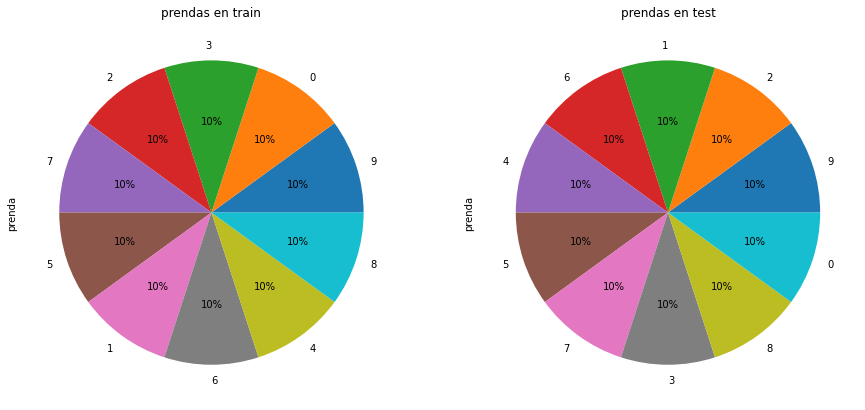

In [8]:
## Armar dataframes solo con los array y
df_train = pd.DataFrame(data=y_train, columns=['prenda'])
df_test = pd.DataFrame(data=y_test, columns=['prenda'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

## Distribución de las 9 clases en train y test
df_train.prenda.value_counts().plot.pie(autopct='%1.0f%%', figsize=(15,15), ax=axes[0])
axes[0].set_title('prendas en train')
df_test.prenda.value_counts().plot.pie(autopct='%1.0f%%', figsize=(15,15), ax=axes[1])
axes[1].set_title('prendas en test')

Claramente, los dos conjuntos de datos **train** y **test** siguen la misma distribucion uniforme discreta, los dos conjuntos estan perfectamente balanceados en un 10% por cada clase

### 2. Machine Learning

La métrica **Accuracy** es la que mejor se ajusta al problema para poder juzgar los modelos ya que se tiene un conjunto de datos perfectamente balanceado y las clases tienen todas el mismo peso.

A continuación, se prueba una red neuronal simple MLP

In [44]:
datasets = ((('train'),(x_train,y_train)),(('test'),(x_test,y_test)))


## Funcion para evaluar los modelos
def evaluar_modelo(history, datasets, model):
    plt.figure(figsize=(9, 5))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)
        x , y = dataset
        f,a,l, = (x.shape)
        x = x.reshape(f,a,l,1)    
        ds = NumpyArrayIterator(x,
                                y,
                                image_data_generator=ImageDataGenerator(),
                                batch_size=64,
                                shuffle=1,
                                seed=747
                               )

        batch_images, batch_labels = ds.next()
        predictions = np.argmax(model.predict(batch_images), axis=-1)

        accuracy_score(predictions, batch_labels)
        
        print('accuracy', accuracy_score(batch_labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(8, 8))

        plt.xticks([*PRENDAS.keys()], [*PRENDAS.values()], rotation=45)
        plt.yticks([*PRENDAS.keys()], [*PRENDAS.values()])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(batch_labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [10]:
model_mlp_1 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Rescaling(1/255),
    Dense(10, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_mlp_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_mlp_1 = model_mlp_1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test,y_test)
)

Epoch 1/10
1875/1875 [==============================] - 13s 5ms/step - loss: 0.8363 - accuracy: 0.7424 - val_loss: 0.5342 - val_accuracy: 0.8183
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5501 - accuracy: 0.8187 - val_loss: 0.4870 - val_accuracy: 0.8337
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5068 - accuracy: 0.8335 - val_loss: 0.5150 - val_accuracy: 0.8131
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4857 - accuracy: 0.8392 - val_loss: 0.4619 - val_accuracy: 0.8361
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4673 - accuracy: 0.8435 - val_loss: 0.4374 - val_accuracy: 0.8493
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4601 - accuracy: 0.8460 - val_loss: 0.4269 - val_accuracy: 0.8526
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4442 - accuracy: 0.8512 - val_loss: 0.4381 - val_accuracy

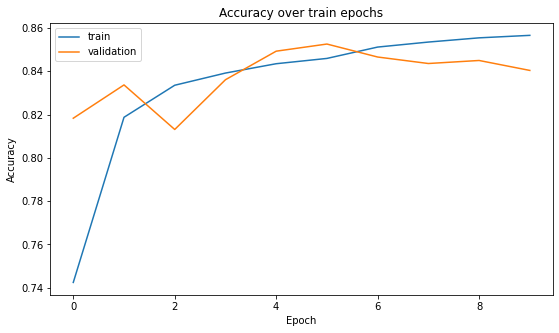

######################### train #########################
accuracy 0.890625


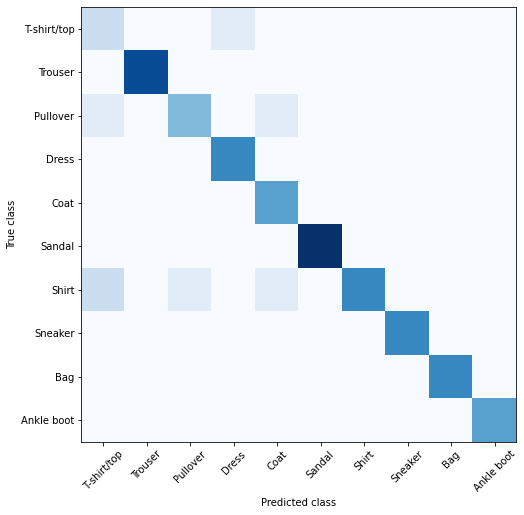

######################### test #########################
accuracy 0.796875


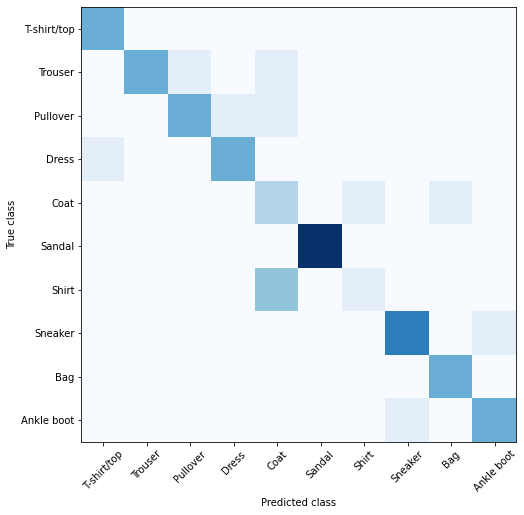

In [11]:
evaluar_modelo(history_mlp_1, datasets, model_mlp_1)

Con una red clásica MLP de 3 capas densas de 10 redes cada una con una activación de tangente hiperbólica y una capa de Dropout que apaga solo el 20% de las conexiones ante la capa de salida entrenando durante 10 épocas con batchs de 32 imagenes se observan resultados en el que **train y test** convergen aproximadamente en el 85% de **Accuracy**. Si se seguiria entrenando problamente se mejore la métrica pero no mucho mas. 

Se intentará mejorar el resultado del modelo

In [12]:
model_mlp_2 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Rescaling(1/255),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_mlp_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_mlp_2 = model_mlp_2.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test,y_test)
)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0118 - accuracy: 0.6194 - val_loss: 0.6094 - val_accuracy: 0.7841
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.7087 - accuracy: 0.7388 - val_loss: 0.5537 - val_accuracy: 0.8039
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6599 - accuracy: 0.7536 - val_loss: 0.5255 - val_accuracy: 0.8149
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6359 - accuracy: 0.7653 - val_loss: 0.5196 - val_accuracy: 0.8126
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6173 - accuracy: 0.7725 - val_loss: 0.5044 - val_accuracy: 0.8211
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6041 - accuracy: 0.7753 - val_loss: 0.5015 - val_accuracy: 0.8195
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5896 - accuracy: 0.7796 - val_loss: 0.5044 - val_accuracy:

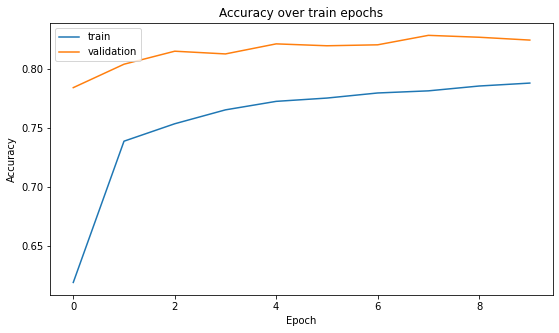

######################### train #########################
accuracy 0.828125


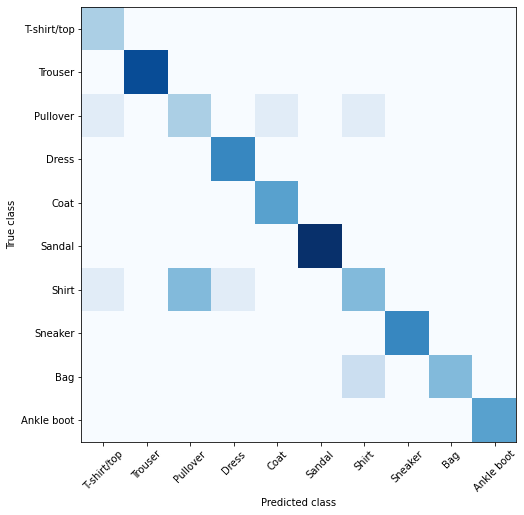

######################### test #########################
accuracy 0.8125


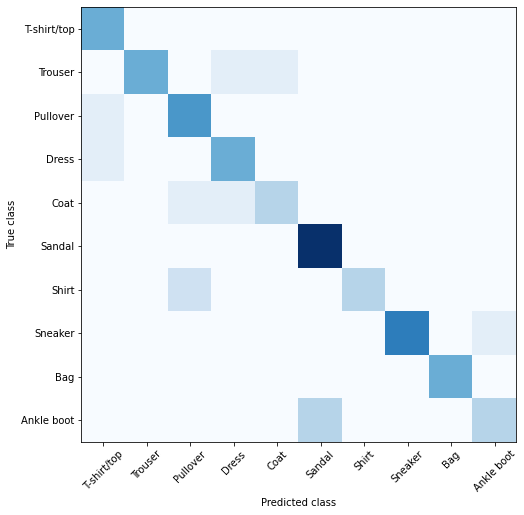

In [13]:
evaluar_modelo(history_mlp_2, datasets,model_mlp_2)

Evaluada la misma red pero con activación Relu el rendimiento cae un poco y le cuesta mas converger. También se ve que la Accuracy para validation es mejor que para test por unos puntos porcentuales, esto puede deberse a que en validation hay caso mas fácil de aprender o el dropout del 20% en la capa de salida está evitando que la red aprenda todo lo que pueda.

In [14]:
model_mlp_3 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Rescaling(1/255),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dropout(0.1),
    Dense(20, activation='relu'),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_mlp_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_mlp_3 = model_mlp_3.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test),
    use_multiprocessing=True
)

Epoch 1/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6901 - accuracy: 0.7561 - val_loss: 0.4854 - val_accuracy: 0.8320
Epoch 2/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4799 - accuracy: 0.8292 - val_loss: 0.4571 - val_accuracy: 0.8376
Epoch 3/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4396 - accuracy: 0.8410 - val_loss: 0.4617 - val_accuracy: 0.8338
Epoch 4/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4143 - accuracy: 0.8514 - val_loss: 0.4194 - val_accuracy: 0.8492
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3952 - accuracy: 0.8577 - val_loss: 0.4111 - val_accuracy: 0.8508
Epoch 6/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3830 - accuracy: 0.8630 - val_loss: 0.3936 - val_accuracy: 0.8565
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3715 - accuracy: 0.8647 - val_loss: 0.3999 - val_accuracy:

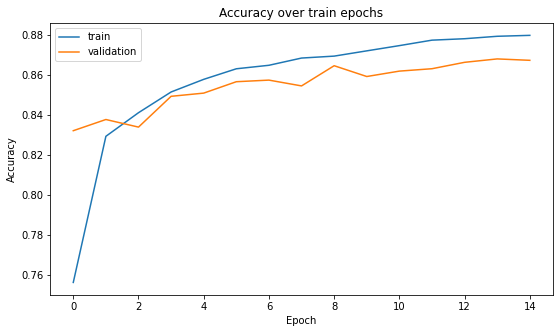

######################### train #########################
accuracy 0.890625


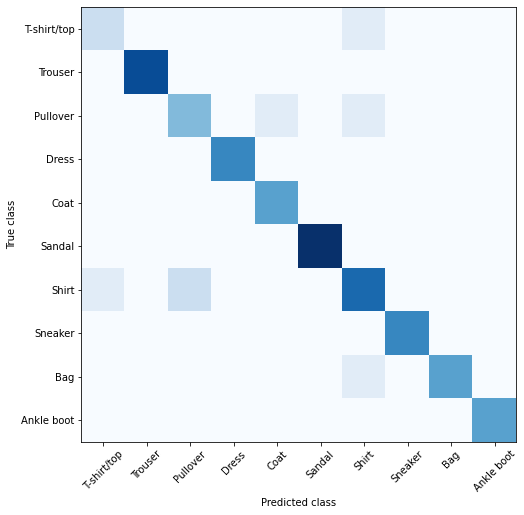

######################### test #########################
accuracy 0.90625


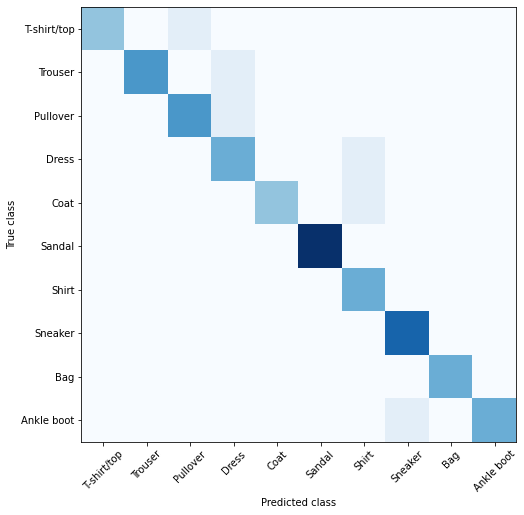

In [15]:
evaluar_modelo(history_mlp_3, datasets, model_mlp_3)

Se entrenó la red mlp_3 de activación Relu con 20 neuronas por capa y se redujo el dropout al 10% para que la red aprenda más. Se lograron mejores resultados en batchs de 32 pero con 15 épocas. Ahora train tiene mejores resultados que validation como es de esperar. Con más capas, más neuronas y mas épocas esta red alcanza resultados similares a la red mlp_1.

In [16]:
model_mlp_4 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Rescaling(1/255),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_mlp_4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)


history_mlp_4 = model_mlp_4.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test)
)



Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5690 - accuracy: 0.8071 - val_loss: 0.4471 - val_accuracy: 0.8433
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4114 - accuracy: 0.8557 - val_loss: 0.4136 - val_accuracy: 0.8548
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3786 - accuracy: 0.8661 - val_loss: 0.3865 - val_accuracy: 0.8584
Epoch 4/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3579 - accuracy: 0.8724 - val_loss: 0.3802 - val_accuracy: 0.8614
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3465 - accuracy: 0.8758 - val_loss: 0.3832 - val_accuracy: 0.8639
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3336 - accuracy: 0.8799 - val_loss: 0.3812 - val_accuracy: 0.8636
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3228 - accuracy: 0.8845 - val_loss: 0.3702 - val_accuracy:

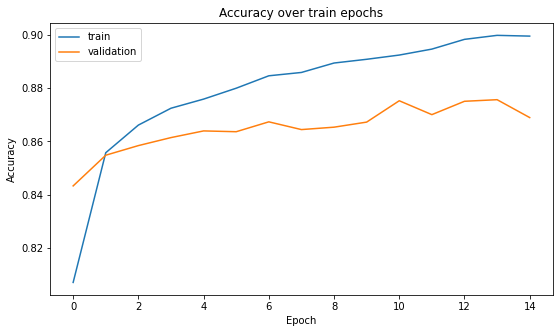

######################### train #########################
accuracy 0.890625


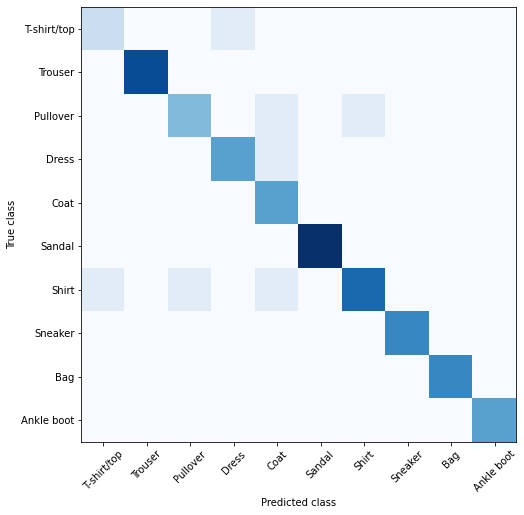

######################### test #########################
accuracy 0.90625


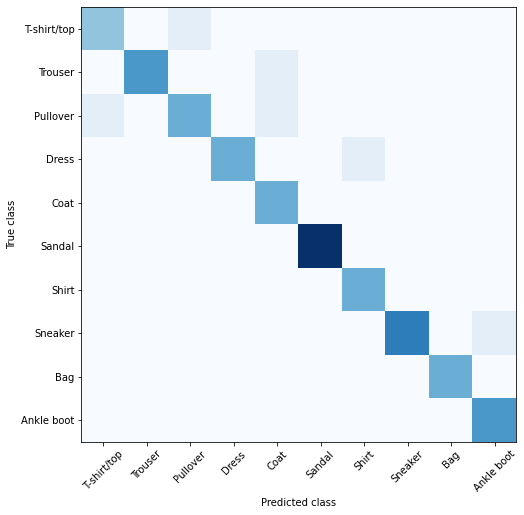

In [17]:
evaluar_modelo(history_mlp_4, datasets, model_mlp_4)

Se retomó la arquitectura de la red mlp_1 para mejorarla. Con 3 capas de 30 neuronas cada una, el mismo dropout del 20%, pero con 15 épocas se observan mejores resultados con mas del 85% de Accuracy en test, el gráfico muestra una tendencia de validation a seguir subiendo. Las matrices de confusión en general muestran que los modelos se confuden más con las prendas que tienen forma de remera, como Pullover, T-shirt, Dress

A continuación, se usaran redes convolucionales

In [18]:
model_cnn_1 = Sequential([
    Convolution2D(input_shape=(28,28,1), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(4, 4)),
    Rescaling(1/255),
    Flatten(),
    Dense(10, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_cnn_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_cnn_1 = model_cnn_1.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test),
    use_multiprocessing=True
)

Epoch 1/15
1875/1875 [==============================] - 14s 3ms/step - loss: 0.8299 - accuracy: 0.7395 - val_loss: 0.5288 - val_accuracy: 0.8118
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5199 - accuracy: 0.8250 - val_loss: 0.4441 - val_accuracy: 0.8418
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4639 - accuracy: 0.8446 - val_loss: 0.4042 - val_accuracy: 0.8599
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4341 - accuracy: 0.8541 - val_loss: 0.3922 - val_accuracy: 0.8589
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4128 - accuracy: 0.8621 - val_loss: 0.3704 - val_accuracy: 0.8707
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4012 - accuracy: 0.8647 - val_loss: 0.3720 - val_accuracy: 0.8637
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3902 - accuracy: 0.8682 - val_loss: 0.3624 - val_accuracy

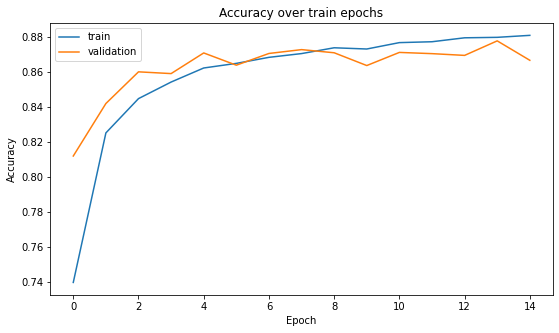

######################### train #########################
accuracy 0.90625


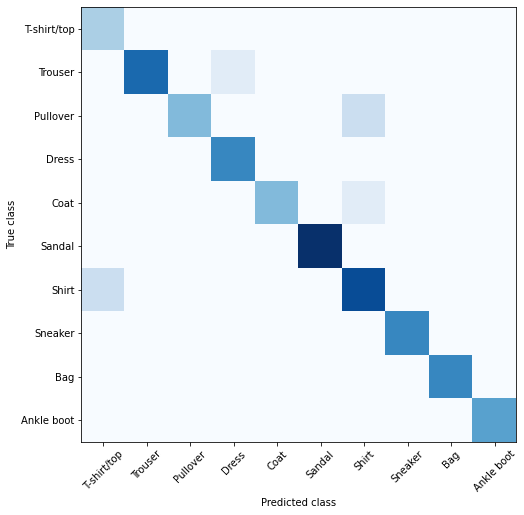

######################### test #########################
accuracy 0.875


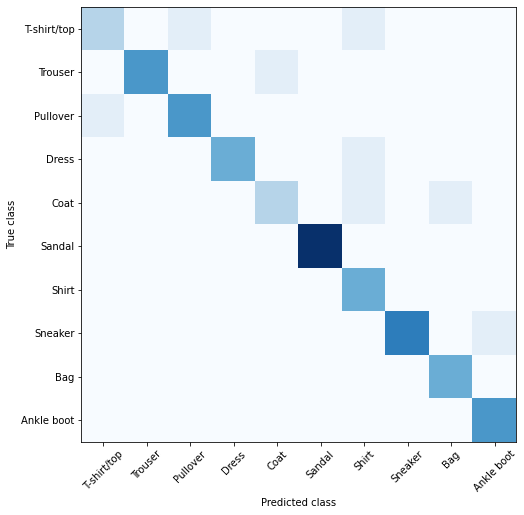

In [19]:
evaluar_modelo(history_cnn_1, datasets, model_cnn_1)

Utilizando una arquitectura de red con una primera capa de convolución de 8 filtros de 4x4 con activacion relu, 2 capas dropout del 20%, max pooling y 3 capas densas de 10 neuronas se logran mejores resultados que el modelo mlp_4 pero ademas tienen una tendencia a seguir mejorando sin sobreentrenar.

Por lo tanto se intentará lo recién mencionado

In [20]:
model_cnn_2 = Sequential([
    
    Convolution2D(input_shape=(28,28,1), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(4, 4)),
    
    
    Rescaling(1/255),
    Flatten(),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])

model_cnn_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_cnn_2 = model_cnn_2.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test),
    use_multiprocessing=True
)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5772 - accuracy: 0.7957 - val_loss: 0.4290 - val_accuracy: 0.8431
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3976 - accuracy: 0.8583 - val_loss: 0.3765 - val_accuracy: 0.8628
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3588 - accuracy: 0.8718 - val_loss: 0.3646 - val_accuracy: 0.8673
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3389 - accuracy: 0.8781 - val_loss: 0.3460 - val_accuracy: 0.8722
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3219 - accuracy: 0.8822 - val_loss: 0.3298 - val_accuracy: 0.8850
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3091 - accuracy: 0.8880 - val_loss: 0.3288 - val_accuracy: 0.8801
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3011 - accuracy: 0.8923 - val_loss: 0.3293 - val_accuracy:

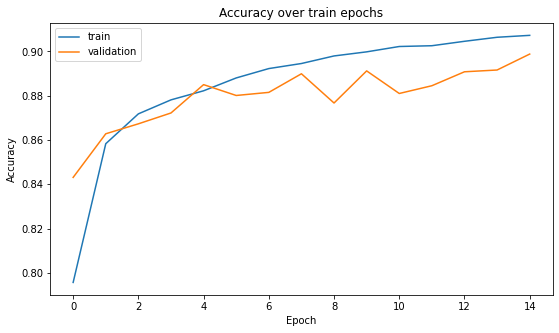

######################### train #########################
accuracy 0.953125


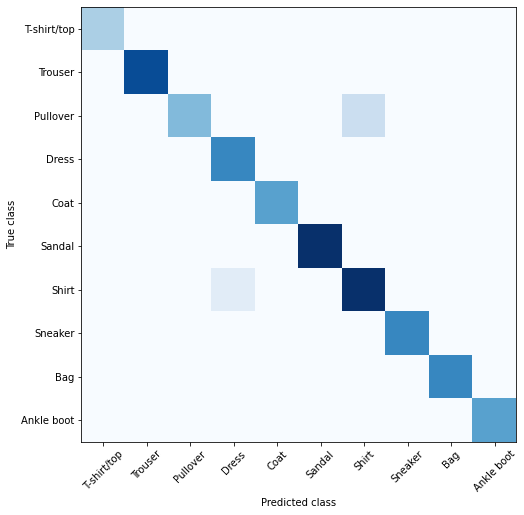

######################### test #########################
accuracy 0.90625


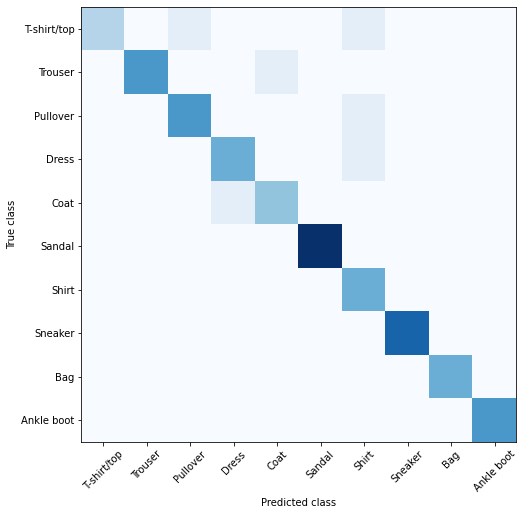

In [21]:
evaluar_modelo(history_cnn_2, datasets, model_cnn_2)

Poniendole 30 neuronas a las capas densas de la red cnn_1 la red cnn_2 mejora hasta valores de accuracy del 89% sin sobreentrenar. Se intentará aumentar mas el rendimiento.

In [22]:
model_cnn_3 = Sequential([
    
    Rescaling(1/255, input_shape=(28,28,1)),
    
    Convolution2D(filters=12, kernel_size=(6, 6), activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=16, kernel_size=(6, 6), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(),
    
    
    Flatten(),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])


model_cnn_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_cnn_3 = model_cnn_3.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test),
    use_multiprocessing=True
)

Epoch 1/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5484 - accuracy: 0.8069 - val_loss: 0.3705 - val_accuracy: 0.8675
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3617 - accuracy: 0.8720 - val_loss: 0.3396 - val_accuracy: 0.8750
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3229 - accuracy: 0.8853 - val_loss: 0.3122 - val_accuracy: 0.8870
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2953 - accuracy: 0.8938 - val_loss: 0.2931 - val_accuracy: 0.8935
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2796 - accuracy: 0.8990 - val_loss: 0.2825 - val_accuracy: 0.8955
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2669 - accuracy: 0.9038 - val_loss: 0.3135 - val_accuracy: 0.8839
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2546 - accuracy: 0.9082 - val_loss: 0.2814 - val_accuracy:

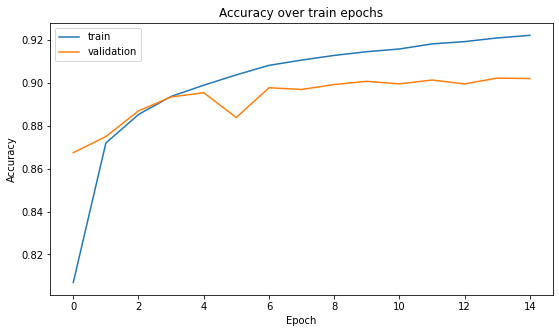

######################### train #########################
accuracy 0.953125


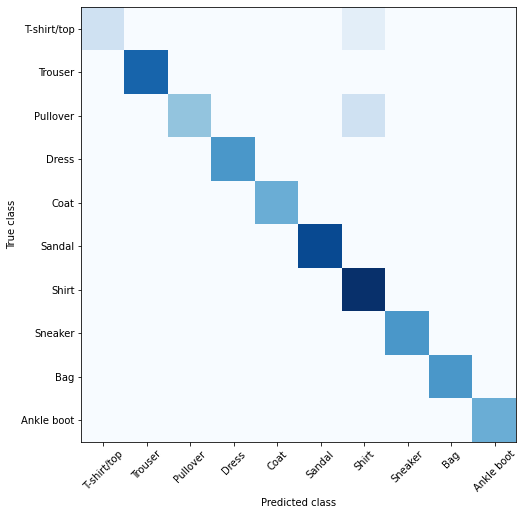

######################### test #########################
accuracy 0.890625


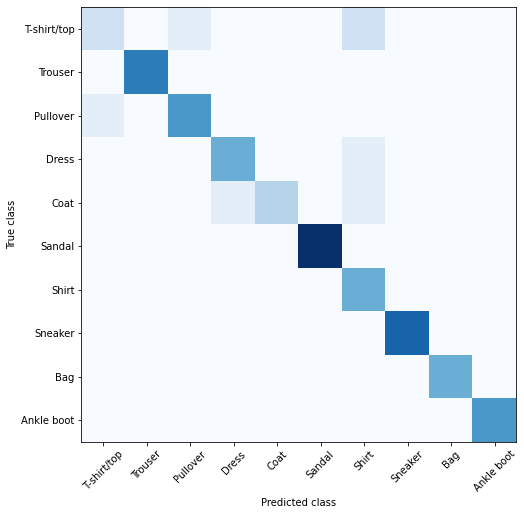

In [25]:
evaluar_modelo(history_cnn_3, datasets, model_cnn_3)

En el último modelo (cnn_3) se le agregó a cnn_2 una capa mas de convolución y se le agregaron 4 filtros a la primera capa y 8 a la segunda. Los resultados son similares apenas mejores, se concluye que un **≈ 90% de accuracy** para **validation** sin sobreentrenar es suficiente para clasificar las prendas. Es decir, la arquitectura de la red tiene la complejidad ajustada para la cantidad de datos que se tienen y puede aprender sin sobreentrenar.

Se pondrán a prueba los últimos modelos aplicando **técnicas de aumentación de datos**, pero no aplicadas al dataset, si no como capas de preprocesamiento en los modelos.

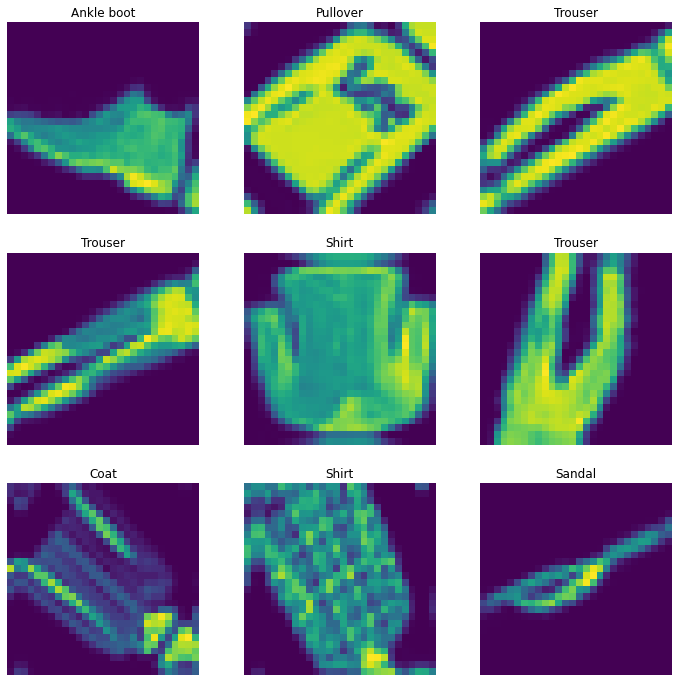

In [315]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, fill_mode="reflect"),
    RandomContrast(0.8),
    RandomZoom(0.1, 0.2),
])

x_sample=[]
y_sample=[]

for i in range(9):
    imagen = x_test[i].reshape(28,28,1)
    imagen_a = Augmentation(imagen, training=True)
    imagen = np.array(imagen_a)
    imagen = imagen.reshape(28,28)
    x_sample.append(imagen)
    y_sample.append(y_test[i])

dibujar_imagenes(x_sample, y_sample) ## Ejemplo de aumentacion de las imagenes


In [30]:
model_cnn_a = Sequential([
    ## preprocesado
    Rescaling(1/255, input_shape=(28,28,1)),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, fill_mode="reflect"),
    RandomContrast(0.8),
    RandomZoom(0.1, 0.2),
    ## preprocesado
    
    ## convoluciones
    Convolution2D(filters=12, kernel_size=(6, 6), activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=16, kernel_size=(6, 6), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(),
    ## convoluciones
        
    Flatten(),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'),  
])


model_cnn_a.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', ## Para etiquetas como enteros y no OHE
    metrics=['accuracy'],
)

history_cnn_a = model_cnn_a.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test,y_test),
    use_multiprocessing=True
)


Epoch 1/15
1875/1875 [==============================] - 11s 5ms/step - loss: 1.2583 - accuracy: 0.5343 - val_loss: 0.8804 - val_accuracy: 0.6758
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9815 - accuracy: 0.6347 - val_loss: 0.8301 - val_accuracy: 0.6775
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9087 - accuracy: 0.6651 - val_loss: 0.7515 - val_accuracy: 0.7288
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8623 - accuracy: 0.6849 - val_loss: 0.7212 - val_accuracy: 0.7351
Epoch 5/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8377 - accuracy: 0.6958 - val_loss: 0.7213 - val_accuracy: 0.7388
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8208 - accuracy: 0.7027 - val_loss: 0.7390 - val_accuracy: 0.7175
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8020 - accuracy: 0.7101 - val_loss: 0.6928 - val_accurac

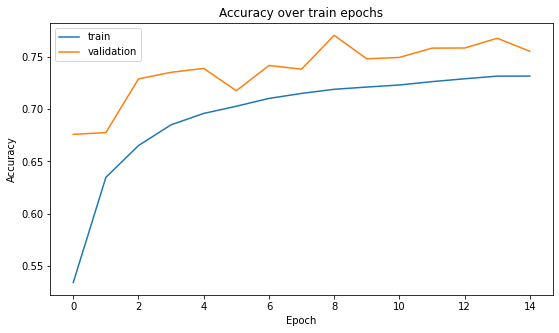

######################### train #########################
accuracy 0.6875


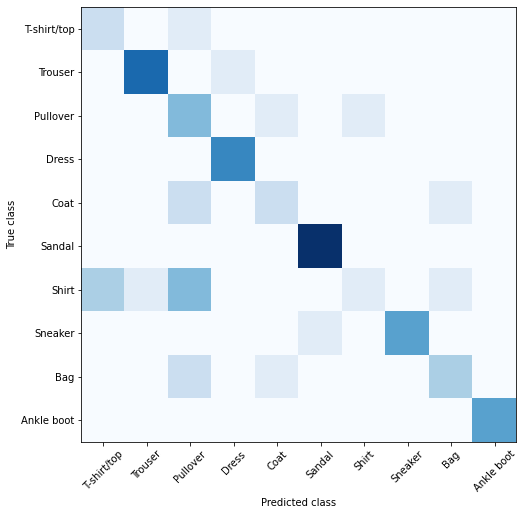

######################### test #########################
accuracy 0.6875


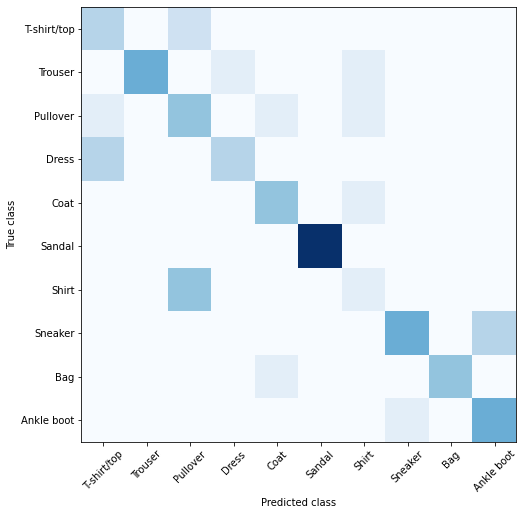

In [31]:
evaluar_modelo(history_cnn_a, datasets, model_cnn_a)

Aplicando técnicas de aumentación de datos al último modelo entrenado (cnn_3) como **dar vuelta, rotar, hacer zoom, o cambiar el contraste** de las imagenes para generar mayor diversidad en los datos, el rendimiento del modelo cae bastante como es de esperar ya que ahora es más dificil aprender ante tantas variaciones. Pero a su vez la ventaja de esto es que se puede evitar mas facilmente el sobreentrenamiento cuando se entrena una red mas potente y se podrian lograr resultados mejores que los anteriores.

Conseguido un 90% de accuracy para validation sin sobreentrenar, se buscará subir la bara pero con modelos pre-entrenados con grandes volumenes de datos por otras personas que estén disponibles en internet.

In [32]:
## Primero preparamos los dataset con el formato que requiere VGG16
## (porque fue entrenada con esos valores) que es 
## minimo 48 pixeles de ancho, 48 pixeles de largo y 3 canales

train_d = np.array([np.array((x_train[i])) for i in range(len(x_train))])
train_d = train_d.flatten().reshape(60000, 784)
test_d = np.array([np.array((x_test[i])) for i in range(len(x_test))])
test_d = test_d.flatten().reshape(10000, 784)

train_data=np.dstack([train_d] * 3)
test_data=np.dstack([test_d]* 3)

train_data = train_data.reshape(-1, 28,28,3)
test_data= test_data.reshape (-1,28,28,3)
train_data.shape,test_data.shape

from keras.preprocessing.image import img_to_array, array_to_img
train_data = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_data])
test_data = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_data])

# Normalise the data and change data type
train_data= train_data / 255.
test_data = test_data / 255.
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data.shape, test_data.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [33]:
model_tl = Sequential([
    
    VGG16(input_shape = (48, 48, 3),
          include_top=False, ## Excluimos la parte de clasificacion
          weights='imagenet'), ## Descargamos los pesos de imagenet
    
    Flatten(),
    
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dense(30, activation='tanh'),
    Dropout(0.2),
    Dense(len(PRENDAS), activation='softmax'), 
])

model_tl.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_tl.layers[0].trainable = False ## Congelamos vgg16

for layer in model_tl.layers: ## Comprobamos que se congelo
    print(layer, layer.trainable)

model_tl.summary()

58900480/58889256 [==============================] - 0s 0us/step
<keras.engine.functional.Functional object at 0x7fb3b20a1e50> False
<keras.layers.core.flatten.Flatten object at 0x7fb3b20a8b10> True
<keras.layers.core.dense.Dense object at 0x7fb3b2096f10> True
<keras.layers.core.dense.Dense object at 0x7fb3b2090c10> True
<keras.layers.core.dense.Dense object at 0x7fb3b20904d0> True
<keras.layers.core.dropout.Dropout object at 0x7fb3b2086110> True
<keras.layers.core.dense.Dense object at 0x7fb3b2086310> True
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 30)                15390     
  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
history_tl = model_tl.fit(
    train_data,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(test_data,y_test),
    use_multiprocessing=True)

Epoch 1/15
1875/1875 [==============================] - 79s 41ms/step - loss: 0.5561 - accuracy: 0.8762 - val_loss: 0.3077 - val_accuracy: 0.9126
Epoch 2/15
1875/1875 [==============================] - 77s 41ms/step - loss: 0.2704 - accuracy: 0.9211 - val_loss: 0.2567 - val_accuracy: 0.9192
Epoch 3/15
1875/1875 [==============================] - 78s 42ms/step - loss: 0.2114 - accuracy: 0.9348 - val_loss: 0.2061 - val_accuracy: 0.9293
Epoch 4/15
1875/1875 [==============================] - 78s 42ms/step - loss: 0.1708 - accuracy: 0.9462 - val_loss: 0.2302 - val_accuracy: 0.9278
Epoch 5/15
1875/1875 [==============================] - 78s 42ms/step - loss: 0.1455 - accuracy: 0.9550 - val_loss: 0.2086 - val_accuracy: 0.9348
Epoch 6/15
1875/1875 [==============================] - 79s 42ms/step - loss: 0.1195 - accuracy: 0.9632 - val_loss: 0.1975 - val_accuracy: 0.9401
Epoch 7/15
1875/1875 [==============================] - 78s 42ms/step - loss: 0.1018 - accuracy: 0.9687 - val_loss: 0.1930 -

Luego de usar **VGG16** como modelo base congelado con los pesos aprendidos en ImageNet y el mismo modelo que mlp_3 (3 capas densas de 30 neuronas) para clasificar, se obtuvieron resultados mejores. Aproximadamente 99% en **train** y 95% en **test**.*texto en cursiva*

# Conclusión


Para ir concluyendo, se pondrá a prueba el último modelo entrenado haciendolo predecir con 10.000 imagenes

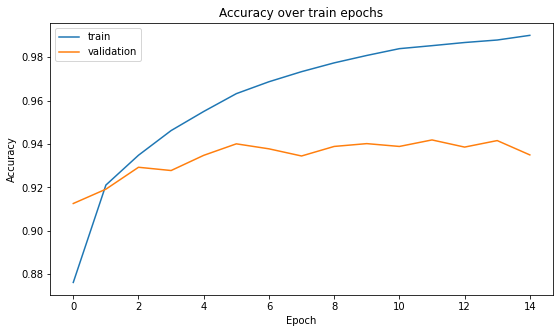

######################### train #########################
accuracy 0.9889


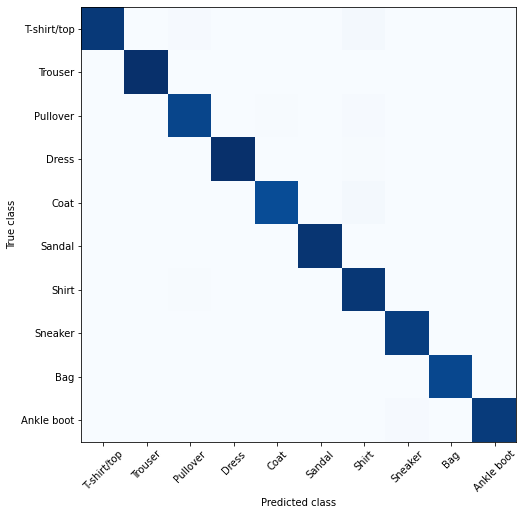

######################### test #########################
accuracy 0.935


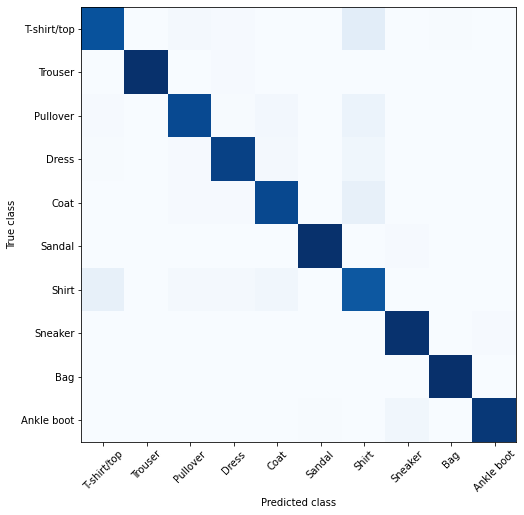

In [287]:
plt.figure(figsize=(9, 5))
plt.plot(history_tl.history['accuracy'], label='train')
plt.plot(history_tl.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

datasets_tl = (('train', (train_data,y_train)), ('test', (test_data,y_test)))

x_pred=[]
y_pred=[]
y_true=[]
for dataset_name, dataset in datasets_tl:
        print('#' * 25, dataset_name, '#' * 25)
        x , y = dataset 
        ds = NumpyArrayIterator(x,y,ImageDataGenerator(),batch_size=10000,shuffle=1,seed=747)

        batch_images, batch_labels = ds.next()
        predictions = np.argmax(model_tl.predict(batch_images), axis=-1)
        
        print('accuracy', accuracy_score(batch_labels, predictions))

        if dataset_name == 'test':
          x_pred=batch_images
          y_pred=predictions
          y_true=batch_labels

        # graficamos la confussion matrix
        plt.figure(figsize=(8, 8))

        plt.xticks([*PRENDAS.keys()], [*PRENDAS.values()], rotation=45)
        plt.yticks([*PRENDAS.keys()], [*PRENDAS.values()])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(batch_labels, predictions,), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()


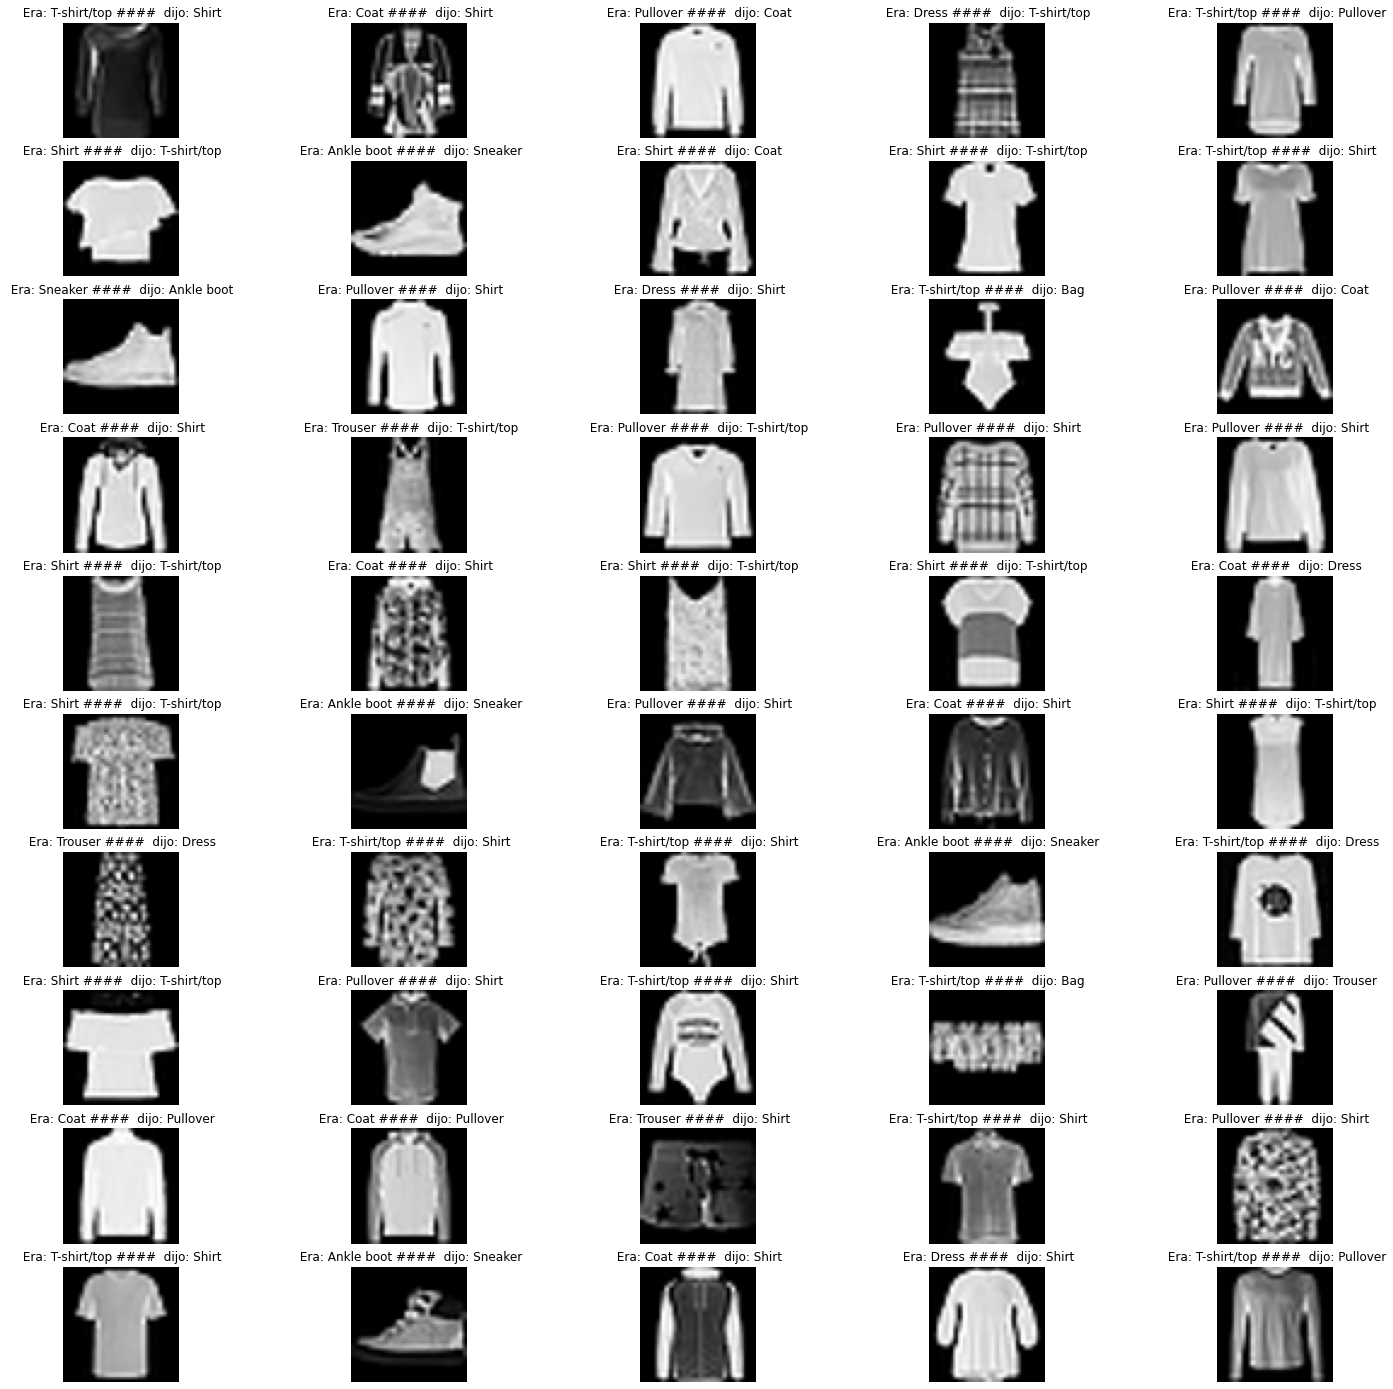

In [290]:
x_pred #numpy array con la imagen a predecir
y_pred #numpy array con predicciones
y_true #numpy array con verdad de esas predicciones

### los tres correlacionados por indices ### 

indices_pred_buenas  = np.where(np.equal(y_pred, y_true))[0] 
indices_pred_malas = np.where(np.not_equal(y_pred, y_true))[0]

x_pred_malas = np.delete(x_pred, indices_pred_buenas, axis=0)
y_pred_malas = np.delete(y_pred, indices_pred_buenas)
y_true_malas = np.delete(y_true, indices_pred_buenas)

## Funcion para dibujar algunas imagenes de ejemplo
def dibujar_imagenes(x_pred, y_pred, y_true):
    plt.figure(figsize=(25, 25))
    for i in range(50):
        plt.subplot(10, 5, i + 1)
        plt.imshow(x_pred_malas[i])
        plt.title(' Era: ' + PRENDAS[y_true[i]] + ' ####  dijo: ' + PRENDAS[y_pred[i]])
        plt.axis("off")

dibujar_imagenes(x_pred_malas, y_pred_malas, y_true_malas)

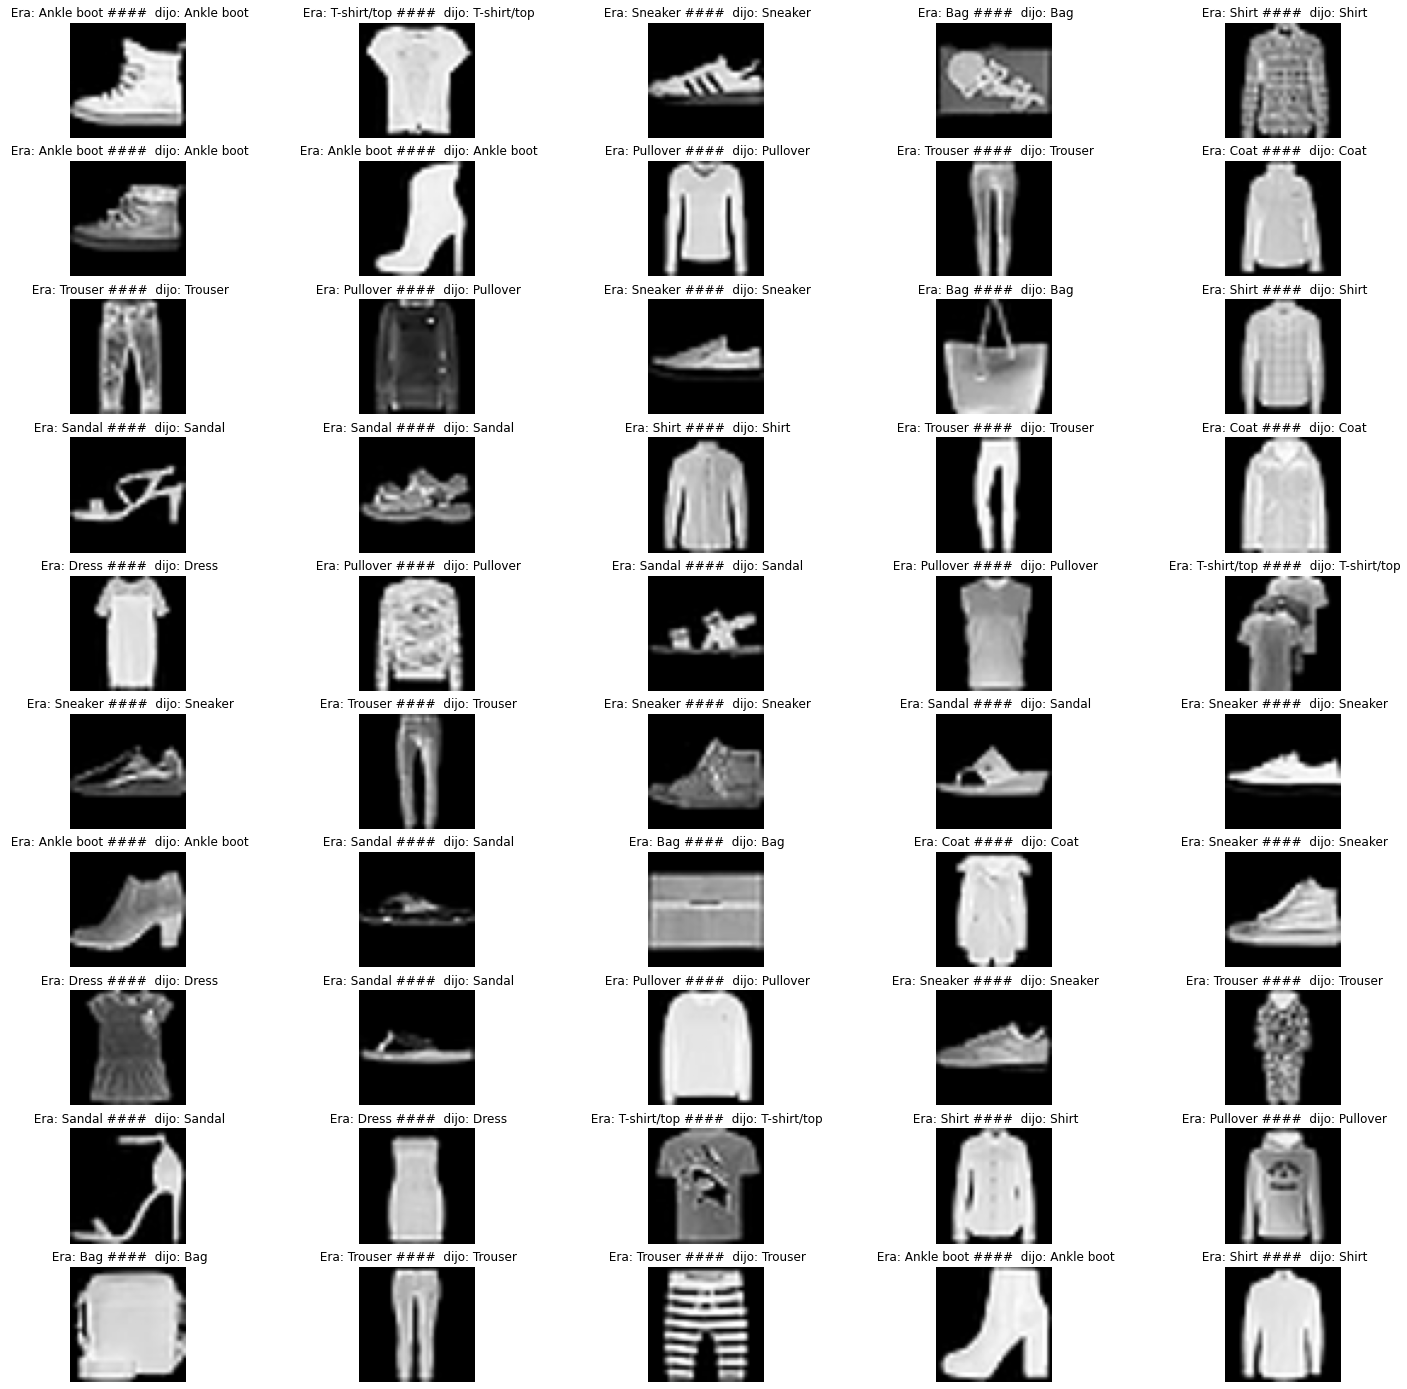

In [292]:
x_pred_buenas = np.delete(x_pred, indices_pred_malas, axis=0)
y_pred_buenas = np.delete(y_pred, indices_pred_malas)
y_true_buenas = np.delete(y_true, indices_pred_malas)


dibujar_imagenes(x_pred_buenas, y_pred_buenas, y_true_buenas)

Considerando las predicciones malas y buenas para cada clase segun el último modelo entrenado **model_tl** y observando las matrices de confusion a lo largo del trabajo y como ya se mencionó antes, los modelos en general se confundieron en las prendas para la parte del pecho como **Dress**, **Shirt**, **T-shirt-top**, **Coat**, **Dress**, **Pullover**. Esto es porque son clases que presentan poca diferencias entre ellas, luego es esperable que al modelo le cueste diferenciar un poco mas que al resto. Tambien las **matrices de confusión** del último modelo entrenado muestra por lo limpian que están como el modelo es mejor que los otros.

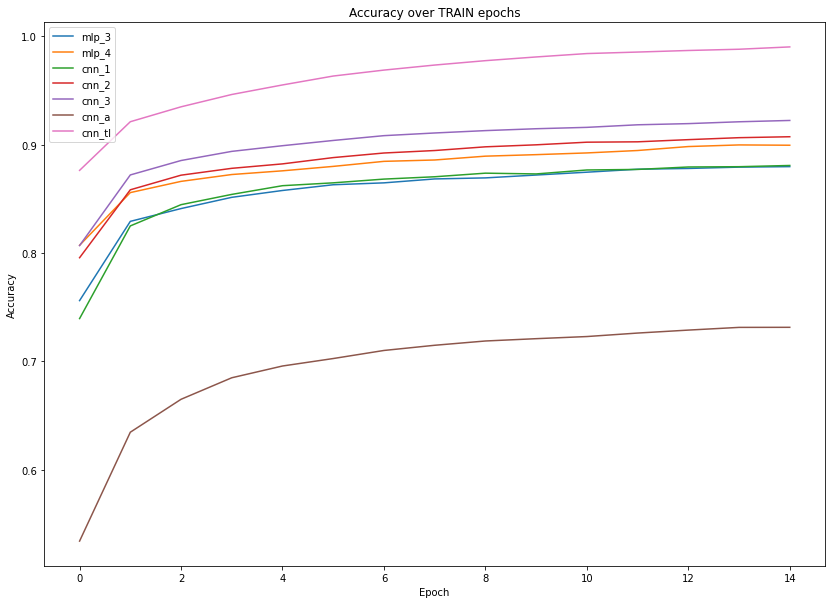

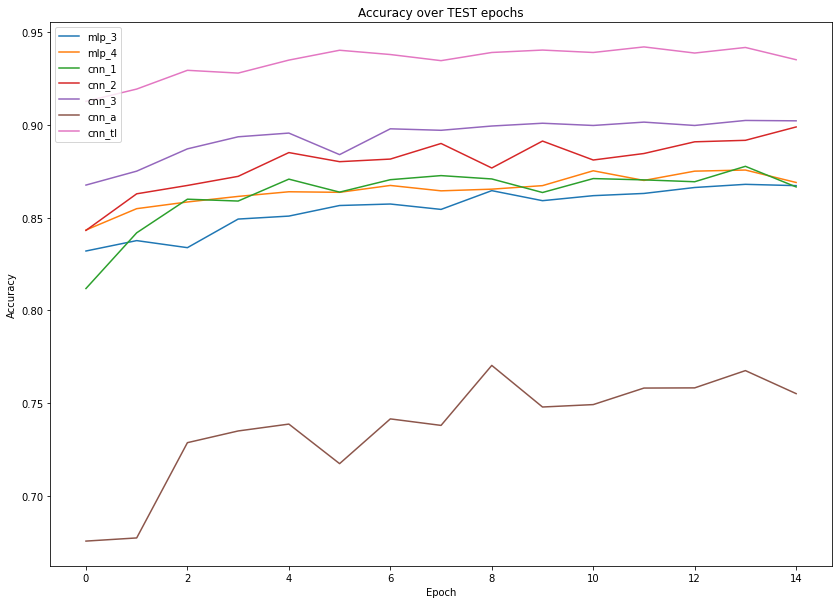

In [39]:
histories = (('mlp_3',history_mlp_3),
            (('mlp_4',history_mlp_4)),
            (('cnn_1',history_cnn_1)),
            (('cnn_2',history_cnn_2)),
            (('cnn_3',history_cnn_3)),
            (('cnn_a',history_cnn_a)),
            (('cnn_tl',history_tl)))

def comparar_modelos(histories):
    plt.figure(figsize=(14, 10))
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=name)
    plt.title('Accuracy over TRAIN epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.figure(figsize=(14, 10))
    for name, history in histories:
        plt.plot(history.history['val_accuracy'], label=name)
    plt.title('Accuracy over TEST epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

comparar_modelos(histories)

Arriba se observa dos gráficos para **TRAIN** y **TEST** respectivamente el desempeño de los modelos entrenados con **batchs de tamaño 32 y 15 épocas**.


La tendencia que muestran los gráficos es que a lo largo de la experimentación se fueron entrenando modelos que mejoraban progresivamente los resultados de *accuracy*. Pasando por redes **MLP simples(mlp_3, mlp_4)** luego por redes **convolucionales (cnn_1, cnn_2, cnn_3)** hasta utilizando **tecnicas de aumentación de datos (cnn_a)** que es donde se ve que el rendimiento cae hasta CNN utilizando **transfer learning** con un modelo base **VGG16** en el que mejora todo lo anterior, como la teoría dicta..

En general todos los modelos superan el **80% de accuracy** tanto en *train* como *test*, menos **cnn_a con aumentacion de datos** donde cae hasta el **70%**. La complejidad de los modelos estuvo bastante ajustada a los datos que se tenian ya que no presentaron grandes **diferencias entre test y validation** marcando un **leve sobreentrenamiento en algunos casos**, aunque tambien las gráficas muestran que durante train el modelo está mucho mas estable y en test hay mas altibajos, este comportamiento parece lógico ya que indica que el modelo no memorizó y aprendió, a la manera en la que también los humanos aprendemos.
